<a href="https://colab.research.google.com/github/FleaBusyBeeBergs/dtsa5511-final-project/blob/main/dtsa5511_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Bank of Canada interest rate changes
DTSA5511 final project


In [1]:
!pip install scikit-learn-intelex -q
#!pip install statsmodels==0.14.0 -q
!pip install tslearn -q
!pip install scikeras -q
!pip install xgboost lightgbm catboost imbalanced-learn -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.5/111.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 389.9/389.9 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 10.7 MB/s eta 0:00:00


In [2]:
# file handling & general
import itertools
import numpy as np
import pandas as pd
import os
from google.colab import files
import xml.etree.ElementTree as ET
import warnings
warnings.filterwarnings('ignore',
                        message = '''.*'force_all_finite' was renamed to 'ensure_all_finite'.*''')
from google.colab import files
from functools import reduce

# http requests
import requests

# vis
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import altair as alt
import seaborn as sns

# ml
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, BatchNormalization, Bidirectional
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam


## 1 Introduction

This project was first created for dtsa 5506, data mining pipeling project. It initially compared a few supervised models and some unsupervised/clustering models, with a brief attempt at a neural network. This updated version of this project is to use deep learning to predict Bank of Canada interest rate changes before they are announced. Interest rates affect nearly everyone and changes to the prevailing rates affect many decisions not just in the long term, but in the short term as well.

The bank of canada exercises counter-inflationary monetary policy by increasing interest to slow inflation, and decreasing interest to allow to avoid recession. To predict changes to the policy interest rate, it would be helpful to first model and predict inflation. The consumer price index is a common measure of inflation, and cpi time series is available from statistics canada.

The use of deep learning is a fairly new tool for central banks in the last decade. Deep learning allows hundreds or even thousands of variables to be used in prediction models.

This project is a classification? Regression? problem that involves time series, so will reuire the use of an LSTM or GRU


### 1.1 The data

In [3]:
# boc rate announcement dates, incl 2025
url = 'https://raw.githubusercontent.com/FleaBusyBeeBergs/dtsa5511-final-project/main/data/rate-announcements.csv'
#url = None
rate_announcements = pd.read_csv(url)
rate_announcements.tail(8)

,date
193,2025-01-29
194,2025-03-12
195,2025-04-16
196,2025-06-04
197,2025-07-30
198,2025-09-17
199,2025-10-29
200,2025-12-10


In [4]:
def preprocess_rate_announcements(rate_announcements):
    '''
    Preprocesses rate announcement data by:
    - Parsing dates
    - Normalizing them to the first day of the month
    - Creating a binary 'announcement' column
    - Renaming 'date' to 'Date'

    Args:
        rate_announcements (pd.DataFrame): DataFrame containing a 'date' column.

    Returns:
        pd.DataFrame: DataFrame with 'Date' column (monthly), and an 'announcement' column.
    '''

    # Ensure 'date' column exists and is datetime
    if 'date' not in rate_announcements.columns:
        raise ValueError("Input DataFrame must contain a 'date' column")

    rate_announcements['date'] = pd.to_datetime(rate_announcements['date'])

    # Normalize to the first day of the month
    rate_announcements['Date'] = rate_announcements['date'].dt.to_period('M').dt.to_timestamp()

    # Add binary flag
    rate_announcements['announcement'] = 1

    # Drop duplicates (e.g., multiple announcements in one month)
    rate_announcements = rate_announcements.drop_duplicates(subset='Date')

    # Keep only the relevant columns
    return rate_announcements[['Date', 'announcement']]

In [5]:
rate_announcements = preprocess_rate_announcements(rate_announcements)
rate_announcements.head()

,Date,announcement
0,2001-01-01,1
1,2001-03-01,1
2,2001-04-01,1
3,2001-05-01,1
4,2001-07-01,1


The data was mined from the Statistics Canada database using XLM

In [6]:
# base URL for data extraction
base_url = 'https://www150.statcan.gc.ca/t1/wds/sdmx/statcan/rest/vector/'

# namespace mappings for XML parsing
namespaces = {
    "message": 'http://www.sdmx.org/resources/sdmxml/schemas/v2_1/message',
    "generic": 'http://www.sdmx.org/resources/sdmxml/schemas/v2_1/data/generic',
    "common": 'http://www.sdmx.org/resources/sdmxml/schemas/v2_1/common',
}

Some data series are reported daily, other series are reported monthly, quarterly or annually. To address the various reporting periods, I need a method to fill the NA values.

In [7]:
class StatCanETL:
    '''ETL pipeline for StatCan data'''

    def __init__(self, table_df):
        '''Initialize with a dataframe of metadata table'''
        self.table_df = table_df
        self.data_objects = {}

    def extract(self, vector, start_period, end_period):
        '''Extract data from the StatCan API for a given vector, start, and end dates'''
        url = f'{base_url}{vector}?startPeriod={start_period}&endPeriod={end_period}&detail=full'
        response = requests.get(url)

        if response.status_code == 200:
            return response.content
        else:
            raise ValueError(f'Failed to fetch data for vector {vector}. HTTP Status: {response.status_code}')

    def transform(self, xml_content, frequency):
        '''Transform the XML response into a structured DataFrame'''
        root = ET.fromstring(xml_content)
        series = root.find('.//generic:Series', namespaces)
        if series is None:
            raise ValueError('No Series element found in the XML response')

        observations = series.findall('.//generic:Obs', namespaces)
        data = []
        for obs in observations:
            obs_dim = obs.find('.//generic:ObsDimension', namespaces)
            obs_val = obs.find('.//generic:ObsValue', namespaces)
            date = obs_dim.attrib['value']

            # Convert date format
            if frequency == 'quarterly':
                date = self.convert_quarter_to_date(date)
            elif frequency == 'yearly':
                date = date[:4] + '-01'

            data.append({
                'Date': date,
                'Value': float(obs_val.attrib['value']),
            })

        df = pd.DataFrame(data)
        return df

    @staticmethod
    def convert_quarter_to_date(quarter_str):
        '''Convert quarterly date string (YYYY-Qx) to standard YYYY-MM format'''
        try:
            year, quarter = quarter_str.split('-Q')
            quarter_start_month = {
                '1': '01',
                '2': '04',
                '3': '07',
                '4': '10',
            }.get(quarter)
            if quarter_start_month:
                return f'{year}-{quarter_start_month}'
            else:
                raise ValueError(f'Invalid quarter format: {quarter_str}')
        except Exception as e:
            raise ValueError(f'Error converting quarter string {quarter_str}: {e}')

    def load(self, df, name):
        '''Load df into global object with name `name` (e.g., wage, rmpi)'''
        globals()[name] = df
        self.data_objects[name] = df
        print(f'Data for {name} saved to object {name}')

    def run(self):
        '''Run the full ETL pipeline for all variables'''
        for _, row in self.table_df.iterrows():
            print(f'Processing {row["name"]}...')
            try:
                # extract
                xml_content = self.extract(row['vector'], row['start'], row['end'])

                # transform
                df = self.transform(xml_content, row['frequency'])

                # load
                self.load(df, row['name'])
            except Exception as e:
                print(f'Error processing {row["name"]}: {e}')


My data mining project included:
* wages
* raw materials price index
* consumer price index
* rate - target

Add?:

Housing starts 34-10-0156 v52299896

Building permits 34-10-0292 v1675119645 avail > 2018-01 only

Retail trade 20-10-0067 v1446870183

Unemployment rate 14-10-0287 v2062815

Employment rate 14-10-0287 v2062817

Labour force participation rate 14-10-0287 v2062816

GDP all industries 36-10-0434 v65201210

manufacturing Industrial Production index 18-10-0267 v1230996350

manufacturing Capacity utilization rate 16-10-0015 v1707053279

1 trading partner US exchange rate 33-10-0036 v111666248 avail > 2017-01

2 trading partner Chinese renminbi exchange rate 33-10-0036 v111666226 avail > 2017-01

3 trading partner Euro 33-10-0036 v111666227 avail > 2017-01

4 trading partner Japanese yen 33-10-0036 v111666231 avail > 2017-01

S&P TSX composite close 10-10-0125 v122620

# nts: to get the table with vector ids, need to select 'download selected data (for database loading)'

In [8]:
# metadata - info to pull from statcan
tables = {
    'name': ['wage', 'rmpi', 'cpi',
             'house_st', # removed building permits & retail
             'unemp', 'empl', 'lab_part',
             'gdp', 'mf_ipi', # removed mf_cap
             'us_fx', 'cn_fx', 'eu_fx',
             'jp_fx', 'tsx_cl', 'rate'],
    'tableid': [14100223, 18100268, 18100004,
                34100156,  # removed building permits & retail
                14100287, 14100287, 14100287,
                36100434, 18100267, # removed mf_cap
                33100036, 33100036, 33100036,
                33100036, 10100125, 10100139],
    'tablename': ['employment and average weekly earnings',
                  'raw materials price index, 2010 = 100',
                  'consumer price index, not seas adj, 2002 = 100',
                  'housing starts',
                  'unemployment rate',
                  'employment rate',
                  'labour force participation rate',
                  'gross domestic product',
                  'manufacturing indust prod idx',
                  'usd exchange rate',
                  'china renminbi exchange rate',
                  'euro exchange rate',
                  'japan yen exchange',
                  's&p tsx close',
                  'bank rate'],
    'vector': ['v79311153', 'v1230998135', 'v41690973',
               'v52299896', # removed bldg & retail
               'v2062815', 'v2062817', 'v2062816',
               'v65201210', 'v1230996350', # removed mf_cap
               'v111666275', 'v111666253', 'v111666254',
               'v111666258', 'v122620', 'v39078'],
    'frequency': ['monthly', 'monthly', 'monthly',
                  'monthly', # removed bldg & retail
                  'monthly', 'monthly', 'monthly',
                  'monthly', 'monthly', # removed mf_cap
                  'monthly', 'monthly', 'monthly',
                  'monthly', 'monthly', 'daily'],
    'start': ['2001-01', '2001-01', '2001-01',
              '2001-01', # removed bldg & retail
              '2001-01','2001-01', '2001-01',
              '2001-01','2001-01', # removed mf_cap
              '2017-01-01', '2017-01-01', '2017-01-01',
              '2017-01-01', '2001-01-01', '2001-01-01'], # if using quarterly data like productivity, format as yyyy-Q#
    'end': ['2024-12', '2024-12', '2024-12',
            '2024-12', # removed bldg & retail
            '2024-12', '2024-12', '2024-12',
            '2024-12', '2024-12', # removed mf_cap
            '2024-12-31', '2024-12-31', '2024-12-31',
            '2024-12-31', '2024-12', '2024-12-31']
}

# make df
table_df = pd.DataFrame(tables)

In [9]:
# run ETL pipe
pipeline = StatCanETL(table_df)
pipeline.run()

Processing wage...
Data for wage saved to object wage
Processing rmpi...
Data for rmpi saved to object rmpi
Processing cpi...
Data for cpi saved to object cpi
Processing house_st...
Data for house_st saved to object house_st
Processing unemp...
Data for unemp saved to object unemp
Processing empl...
Data for empl saved to object empl
Processing lab_part...
Data for lab_part saved to object lab_part
Processing gdp...
Data for gdp saved to object gdp
Processing mf_ipi...
Data for mf_ipi saved to object mf_ipi
Processing us_fx...
Data for us_fx saved to object us_fx
Processing cn_fx...
Data for cn_fx saved to object cn_fx
Processing eu_fx...
Data for eu_fx saved to object eu_fx
Processing jp_fx...
Data for jp_fx saved to object jp_fx
Processing tsx_cl...
Data for tsx_cl saved to object tsx_cl
Processing rate...
Data for rate saved to object rate


In [10]:
# check to see if data loaded correctly
for key, value in pipeline.data_objects.items():
    print(key)
    print(value.head(3), '\n')

wage
      Date   Value
0  2001-01  657.14
1  2001-02  653.59
2  2001-03  655.14 

rmpi
      Date  Value
0  2001-01   65.2
1  2001-02   65.8
2  2001-03   65.5 

cpi
      Date  Value
0  2001-01   96.3
1  2001-02   96.8
2  2001-03   97.1 

house_st
      Date    Value
0  2001-01  141.470
1  2001-02  126.744
2  2001-03  131.271 

unemp
      Date  Value
0  2001-01    6.9
1  2001-02    7.0
2  2001-03    7.1 

empl
      Date  Value
0  2001-01   61.4
1  2001-02   61.3
2  2001-03   61.2 

lab_part
      Date  Value
0  2001-01   65.9
1  2001-02   65.9
2  2001-03   66.0 

gdp
      Date      Value
0  2001-01  1434295.0
1  2001-02  1433843.0
2  2001-03  1434685.0 

mf_ipi
      Date  Value
0  2001-01   77.1
1  2001-02   77.5
2  2001-03   77.8 

us_fx
      Date   Value
0  2017-01  1.3193
1  2017-02  1.3107
2  2017-03  1.3386 

cn_fx
      Date   Value
0  2017-01  0.1914
1  2017-02  0.1907
2  2017-03  0.1941 

eu_fx
      Date   Value
0  2017-01  1.4028
1  2017-02  1.3951
2  2017-03  1.4307 



In [11]:
# Your variable lists
variables = ['wage', 'rmpi', 'cpi', 'house_st', # removed bldg & retail
             'unemp', 'empl', 'lab_part', 'gdp', 'mf_ipi', # removed mf_cap
             'us_fx', 'cn_fx', 'eu_fx', 'jp_fx', 'tsx_cl', 'rate']

daily = ['tsx_cl']  # Excludes 'rate' since we process it separately

def rename_value_column(vars_list):
    """Rename 'Value' column to the variable name."""
    for var in vars_list:
        df = globals()[var]
        df.rename(columns={'Value': var}, inplace=True)

def convert_daily_to_monthly(daily_vars):
    """Convert daily dataframes to monthly averages."""
    for var in daily_vars:
        df = globals()[var].copy()
        df['Date'] = pd.to_datetime(df['Date'])
        df['Month'] = df['Date'].dt.to_period('M').dt.to_timestamp()
        df_monthly = df.groupby('Month', as_index=False)[var].mean()
        df_monthly.rename(columns={'Month': 'Date'}, inplace=True)
        globals()[var] = df_monthly

def preprocess_rate(rate_df):
    """
    Cleans and transforms daily interest rate DataFrame to monthly,
    applying the new rate to the first day of the month of change.
    """
    rate_df['Date'] = pd.to_datetime(rate_df['Date'])
    rate_df['rate'] = pd.to_numeric(rate_df['rate'], errors='coerce')

    rate_df = rate_df.sort_values('Date')
    rate_df['prev_rate'] = rate_df['rate'].shift(1)
    rate_df['rate_changed'] = rate_df['rate'] != rate_df['prev_rate']
    rate_changes = rate_df[rate_df['rate_changed']].copy()
    rate_changes['Date'] = rate_changes['Date'].dt.to_period('M').dt.to_timestamp()
    rate_changes = rate_changes.groupby('Date')['rate'].last().reset_index()
    monthly_rate_df = rate_changes.set_index('Date').resample('MS').ffill().reset_index()
    return monthly_rate_df

def ensure_date_datetime(vars_list):
    """Ensure all 'Date' columns are datetime dtype."""
    for var in vars_list:
        df = globals()[var]
        df['Date'] = pd.to_datetime(df['Date'])

def merge_on_date(vars_list):
    """Merge all dataframes on 'Date' column using outer join."""
    dfs = [globals()[var] for var in vars_list]
    merged = reduce(lambda left, right: pd.merge(left, right, on='Date', how='outer'), dfs)
    return merged

# --- RUN CLEANING PIPELINE ---

# Step 1: Rename 'Value' columns
rename_value_column(variables)

# Step 2: Convert daily FX and equity series to monthly averages
convert_daily_to_monthly(daily)

# Step 3: Preprocess rate series using custom logic
rate = preprocess_rate(rate)  # This replaces the global 'rate'

# Step 4: Ensure all Date columns are datetime
ensure_date_datetime(variables)

# Step 5: Merge all data on Date
data = merge_on_date(variables)

The interest rate data is published (almost) daily, but only changes at 8 pre-determined dates per year. This will require some extra wrangling to align with the other monthly series. Where there is a rate change, I'll apply changed rate to that entire month, effective on the 1st day, so that rate_df can be aligned with the rate announcement data.

In [13]:
# Ensure 'Date' columns are datetime
data['Date'] = pd.to_datetime(data['Date'])
rate_announcements['Date'] = pd.to_datetime(rate_announcements['Date'])

# Merge on 'Date'
merged_data = pd.merge(data, rate_announcements, on='Date', how='left')

# Fill missing values in 'announcement' column with 0
merged_data['announcement'] = merged_data['announcement'].fillna(0).astype(int)

# Optional: set 'Date' as index
merged_data = merged_data.set_index('Date')

In [14]:
print(merged_data.head(2))

              wage  rmpi   cpi  house_st  unemp  empl  lab_part        gdp  \
Date                                                                         
2001-01-01  657.14  65.2  96.3   141.470    6.9  61.4      65.9  1434295.0   
2001-02-01  653.59  65.8  96.8   126.744    7.0  61.3      65.9  1433843.0   

            mf_ipi  us_fx  cn_fx  eu_fx  jp_fx   tsx_cl  rate  announcement  
Date                                                                         
2001-01-01    77.1    NaN    NaN    NaN    NaN  9321.87  5.75             1  
2001-02-01    77.5    NaN    NaN    NaN    NaN  8078.72  5.75             0  


In [15]:
print(merged_data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 288 entries, 2001-01-01 to 2024-12-01
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   wage          288 non-null    float64
 1   rmpi          288 non-null    float64
 2   cpi           288 non-null    float64
 3   house_st      288 non-null    float64
 4   unemp         288 non-null    float64
 5   empl          288 non-null    float64
 6   lab_part      288 non-null    float64
 7   gdp           288 non-null    float64
 8   mf_ipi        288 non-null    float64
 9   us_fx         96 non-null     float64
 10  cn_fx         96 non-null     float64
 11  eu_fx         96 non-null     float64
 12  jp_fx         96 non-null     float64
 13  tsx_cl        273 non-null    float64
 14  rate          288 non-null    float64
 15  announcement  288 non-null    int64  
dtypes: float64(15), int64(1)
memory usage: 38.2 KB
None


* we have 288 months of data
* retail, mf_cap, unavailable from stats can before 2017 - dropped
* building permits series unavailable from stats can before 2018 - dropped
* tsx_cl only avail from stats can until sept 2023 - need to append .csv from yahoo finance.
* fx rates only available from 2017 onwards from stats can. get this info from boc

In [16]:
url = 'https://raw.githubusercontent.com/FleaBusyBeeBergs/dtsa5511-final-project/main/data/fx-2001-2016%20-%20fx-2001-2017.csv'
hist_fx = pd.read_csv(url)
hist_fx['Date'] = pd.to_datetime(hist_fx['date'])
hist_fx = hist_fx.drop(columns=['date'])
hist_fx.tail()

,cn_fx,eu_fx,jp_fx,us_fx,Date
187,0.1954,1.4563,0.01284,1.299323,2016-08-01
188,0.1965,1.4704,0.01288,1.310233,2016-09-01
189,0.1968,1.4594,0.01275,1.325305,2016-10-01
190,0.1963,1.4486,0.01238,1.343990,2016-11-01
191,0.1926,1.4060,0.01150,1.333565,2016-12-01


In [17]:
url = 'https://raw.githubusercontent.com/FleaBusyBeeBergs/dtsa5511-final-project/main/data/tsx_cl-2023-2024.csv'

hist_tsx = pd.read_csv(url)
hist_tsx['tsx_cl'] = hist_tsx['tsx_cl'].str.replace(',', '').astype(float)
hist_tsx['Date'] = pd.to_datetime(hist_tsx['Date'])
hist_tsx['Month'] = hist_tsx['Date'].dt.to_period('M').dt.to_timestamp()

# Group by 'Month' and compute the average (assuming closing value is in 'tsx_cl' column)
tsx_monthly = hist_tsx.groupby('Month', as_index=False)['tsx_cl'].mean()

# Optional: rename 'Month' to 'Date' for consistency
tsx_monthly.rename(columns={'Month': 'Date'}, inplace=True)

# Preview result
print(tsx_monthly.head())
tsx_monthly.head()

        Date        tsx_cl
0 2023-10-01  19204.652381
1 2023-11-01  19897.900000
2 2023-12-01  20590.873684
3 2024-01-01  20976.054545
4 2024-02-01  21116.205000


,Date,tsx_cl
0,2023-10-01,19204.652381
1,2023-11-01,19897.900000
2,2023-12-01,20590.873684
3,2024-01-01,20976.054545
4,2024-02-01,21116.205000


In [18]:
# Merge hist_fx into data on 'Date' using outer join
data = pd.merge(merged_data, hist_fx, on='Date', how='outer', suffixes=('', '_hist'))

# For each fx column, fill missing values using the historical version
fx_vars = ['us_fx', 'cn_fx', 'eu_fx', 'jp_fx']

for var in fx_vars:
    hist_col = f"{var}_hist"
    if hist_col in data.columns:
        data[var] = data[var].fillna(data[hist_col])
        data.drop(columns=hist_col, inplace=True)

print(data.head())

        Date    wage  rmpi   cpi  house_st  unemp  empl  lab_part        gdp  \
0 2001-01-01  657.14  65.2  96.3   141.470    6.9  61.4      65.9  1434295.0   
1 2001-02-01  653.59  65.8  96.8   126.744    7.0  61.3      65.9  1433843.0   
2 2001-03-01  655.14  65.5  97.1   131.271    7.1  61.2      66.0  1434685.0   
3 2001-04-01  652.44  65.2  97.8   144.474    7.1  61.3      66.0  1433399.0   
4 2001-05-01  652.28  65.3  98.6   139.901    7.0  61.3      66.0  1439506.0   

   mf_ipi     us_fx   cn_fx   eu_fx     jp_fx   tsx_cl  rate  announcement  
0    77.1  1.502864  0.1816  1.4099  0.012875  9321.87  5.75             1  
1    77.5  1.523125  0.1839  1.4008  0.013096  8078.72  5.75             0  
2    77.8  1.558441  0.1883  1.4154  0.012829  7608.00  5.25             1  
3    78.2  1.558495  0.1882  1.3906  0.012588  7946.63  5.00             1  
4    78.5  1.541123  0.1862  1.3482  0.012670  8161.87  4.75             1  


In [19]:
print(tsx_monthly.columns)
print(tsx_monthly.head())


Index(['Date', 'tsx_cl'], dtype='object')
        Date        tsx_cl
0 2023-10-01  19204.652381
1 2023-11-01  19897.900000
2 2023-12-01  20590.873684
3 2024-01-01  20976.054545
4 2024-02-01  21116.205000


In [20]:
# 1. Reset index so 'Date' becomes a column
data = data.reset_index()

# 2. Ensure Date columns match format
data['Date'] = pd.to_datetime(data['Date']).dt.to_period('M').dt.to_timestamp()
tsx_monthly['Date'] = pd.to_datetime(tsx_monthly['Date']).dt.to_period('M').dt.to_timestamp()

# 3. Merge new TSX values
data = pd.merge(data, tsx_monthly, on='Date', how='left', suffixes=('', '_new'))

# 4. Use new tsx_cl values if available
data['tsx_cl'] = data['tsx_cl_new'].combine_first(data['tsx_cl'])

# 5. Drop temporary column
data.drop(columns=['tsx_cl_new'], inplace=True)

# 6. Restore index
data = data.set_index('Date')

# 7. Confirm it worked
print(data.loc['2023-09-01':'2024-02-01', ['tsx_cl']])

                  tsx_cl
Date                    
2023-09-01  19541.270000
2023-10-01  19204.652381
2023-11-01  19897.900000
2023-12-01  20590.873684
2024-01-01  20976.054545
2024-02-01  21116.205000


In [22]:
data.head()

,index,wage,rmpi,cpi,house_st,unemp,empl,lab_part,gdp,mf_ipi,us_fx,cn_fx,eu_fx,jp_fx,tsx_cl,rate,announcement
Date,,,,,,,,,,,,,,,,,
2001-01-01,0,657.14,65.2,96.3,141.470,6.9,61.4,65.9,1434295.0,77.1,1.502864,0.1816,1.4099,0.012875,9321.87,5.75,1
2001-02-01,1,653.59,65.8,96.8,126.744,7.0,61.3,65.9,1433843.0,77.5,1.523125,0.1839,1.4008,0.013096,8078.72,5.75,0
2001-03-01,2,655.14,65.5,97.1,131.271,7.1,61.2,66.0,1434685.0,77.8,1.558441,0.1883,1.4154,0.012829,7608.00,5.25,1
2001-04-01,3,652.44,65.2,97.8,144.474,7.1,61.3,66.0,1433399.0,78.2,1.558495,0.1882,1.3906,0.012588,7946.63,5.00,1
2001-05-01,4,652.28,65.3,98.6,139.901,7.0,61.3,66.0,1439506.0,78.5,1.541123,0.1862,1.3482,0.012670,8161.87,4.75,1


In [21]:
# descriptive stats
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 288 entries, 2001-01-01 to 2024-12-01
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   index         288 non-null    int64  
 1   wage          288 non-null    float64
 2   rmpi          288 non-null    float64
 3   cpi           288 non-null    float64
 4   house_st      288 non-null    float64
 5   unemp         288 non-null    float64
 6   empl          288 non-null    float64
 7   lab_part      288 non-null    float64
 8   gdp           288 non-null    float64
 9   mf_ipi        288 non-null    float64
 10  us_fx         288 non-null    float64
 11  cn_fx         288 non-null    float64
 12  eu_fx         288 non-null    float64
 13  jp_fx         288 non-null    float64
 14  tsx_cl        288 non-null    float64
 15  rate          288 non-null    float64
 16  announcement  288 non-null    int64  
dtypes: float64(15), int64(2)
memory usage: 48.6 KB


In [49]:
data.describe()

,Date,wage,rmpi,cpi,house_st,unemp,empl,lab_part,gdp,mf_ipi,us_fx,cn_fx,eu_fx,jp_fx,tsx_cl,rate,announcement
count,288,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,2.880000e+02,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000
mean,2012-12-15 17:00:00,911.699514,99.124653,123.738542,191.275632,6.979167,61.790625,66.427778,1.836635e+06,94.009722,1.239341,0.175529,1.465478,0.011273,13705.173079,2.242188,0.666667
min,2001-01-01 00:00:00,652.280000,55.300000,96.300000,95.831000,4.800000,51.900000,60.100000,1.433233e+06,74.800000,0.955770,0.130000,1.230700,0.008420,6180.420000,0.500000,0.000000
25%,2006-12-24 06:00:00,772.157500,84.075000,109.775000,173.356250,6.200000,61.400000,65.800000,1.656228e+06,82.275000,1.091370,0.155500,1.406375,0.010247,11227.772500,1.000000,0.000000
50%,2012-12-16 12:00:00,903.520000,97.050000,122.200000,189.005500,7.000000,61.800000,66.300000,1.806828e+06,92.000000,1.264557,0.184550,1.464800,0.011580,13540.580000,1.750000,1.000000
75%,2018-12-08 18:00:00,1009.772500,112.725000,134.225000,209.608000,7.500000,62.400000,67.200000,2.042136e+06,99.625000,1.342275,0.192825,1.533150,0.012225,16028.565000,3.250000,1.000000
max,2024-12-01 00:00:00,1291.170000,166.600000,162.100000,290.954000,14.200000,63.600000,67.700000,2.285235e+06,132.700000,1.599618,0.216300,1.680700,0.013600,25187.447368,5.750000,1.000000
std,NaN,170.201881,24.301023,17.143681,31.992781,1.169822,1.211767,0.915636,2.395457e+05,15.301474,0.164430,0.020802,0.090064,0.001255,4202.143176,1.522531,0.472225


In [23]:
data.reset_index(inplace=True)


In [24]:
data.drop(columns = 'index', inplace  = True)
data.head(2)

,Date,wage,rmpi,cpi,house_st,unemp,empl,lab_part,gdp,mf_ipi,us_fx,cn_fx,eu_fx,jp_fx,tsx_cl,rate,announcement
0,2001-01-01,657.14,65.2,96.3,141.470,6.9,61.4,65.9,1434295.0,77.1,1.502864,0.1816,1.4099,0.012875,9321.87,5.75,1
1,2001-02-01,653.59,65.8,96.8,126.744,7.0,61.3,65.9,1433843.0,77.5,1.523125,0.1839,1.4008,0.013096,8078.72,5.75,0


for plotting, data will need to be scaled

In [42]:
numeric_cols = data.columns.drop('Date')

#  scaling
scaler = StandardScaler()
scaled_array = scaler.fit_transform(data[numeric_cols])

# Create scaled DataFrame with same column names and original 'Date'
data_scaled = pd.DataFrame(scaled_array, columns=numeric_cols)
data_scaled.insert(0, 'Date', data['Date'])  # Add Date column back


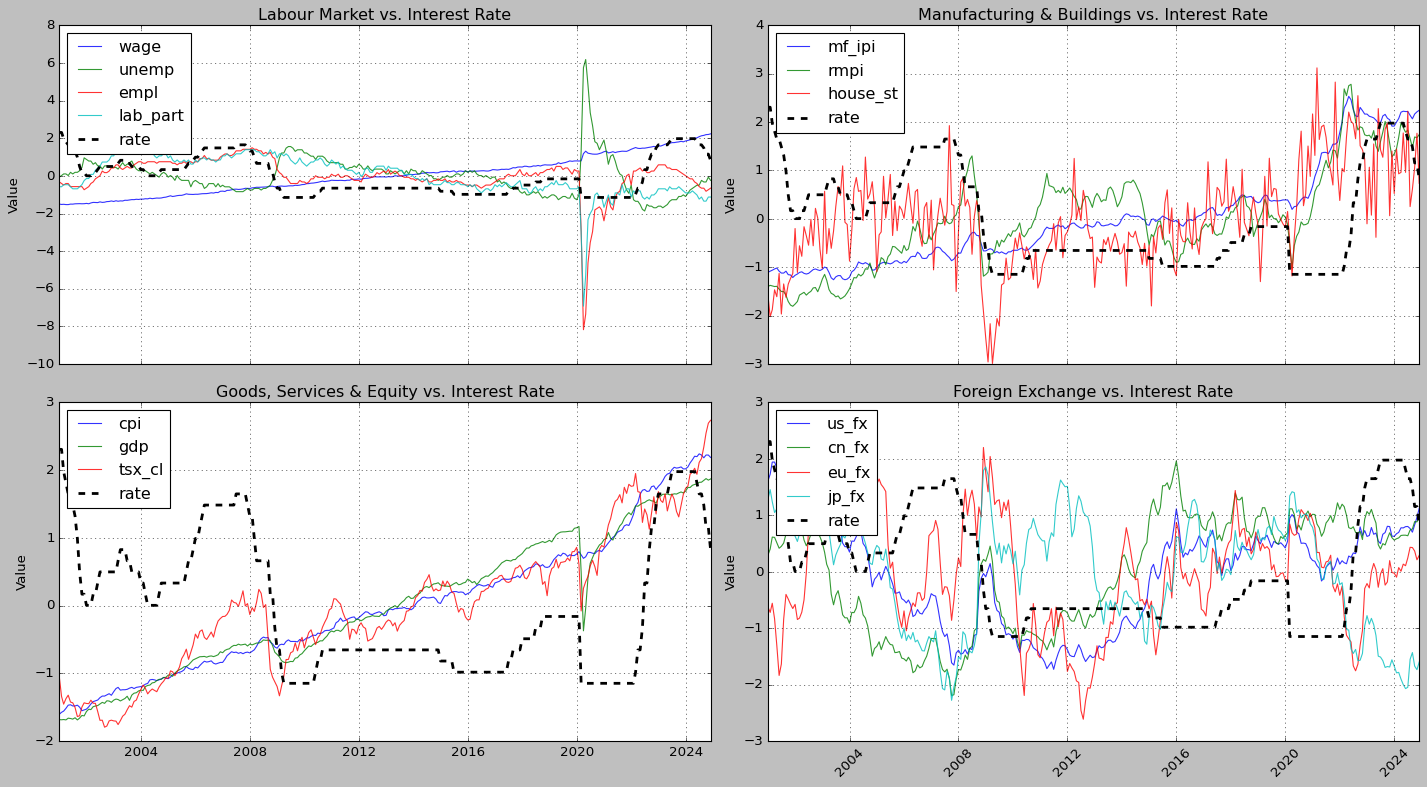

In [43]:
# Set plotting style
plt.style.use('classic')

# Groups of variables
labour_vars = ['wage', 'unemp', 'empl', 'lab_part']
mf_vars     = ['mf_ipi', 'rmpi', 'house_st']
gs_vars     = ['cpi', 'gdp', 'tsx_cl']
fx_vars     = ['us_fx', 'cn_fx', 'eu_fx', 'jp_fx']
groups = {
    'Labour Market': labour_vars,
    'Manufacturing & Buildings': mf_vars,
    'Goods, Services & Equity': gs_vars,
    'Foreign Exchange': fx_vars
}

# Plot each group with 'rate'
fig, axes = plt.subplots(2, 2, figsize=(18, 10), sharex=True)
axes = axes.flatten()

for i, (title, vars_) in enumerate(groups.items()):
    ax = axes[i]

    # Plot each variable in the group
    for var in vars_:
        ax.plot(data_scaled['Date'], data_scaled[var], label=var, alpha=0.8)

    # Plot 'rate' on the same axis (or use a twin axis if needed)
    ax.plot(data_scaled['Date'], data_scaled['rate'], label='rate', color='black', linewidth=2.5, linestyle='--')

    ax.set_title(f'{title} vs. Interest Rate')
    ax.set_ylabel('Value')
    ax.legend(loc='upper left')
    ax.grid(True)

# Format x-axis labels
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [44]:
exclude_cols = ['Date', 'rate', 'announcement']
feature_cols = [col for col in data.columns if col not in exclude_cols]

correlation_matrix = data[feature_cols + ['rate']].corr()
rate_correlation = correlation_matrix['rate'].drop(labels=['rate']).sort_values(ascending=False)

print(rate_correlation)


empl        0.426305
us_fx       0.255054
lab_part    0.200855
house_st    0.161438
eu_fx       0.055311
rmpi        0.050729
mf_ipi      0.048921
tsx_cl      0.007106
cpi        -0.044501
gdp        -0.103649
wage       -0.118164
cn_fx      -0.256279
unemp      -0.458009
jp_fx      -0.503754
Name: rate, dtype: float64


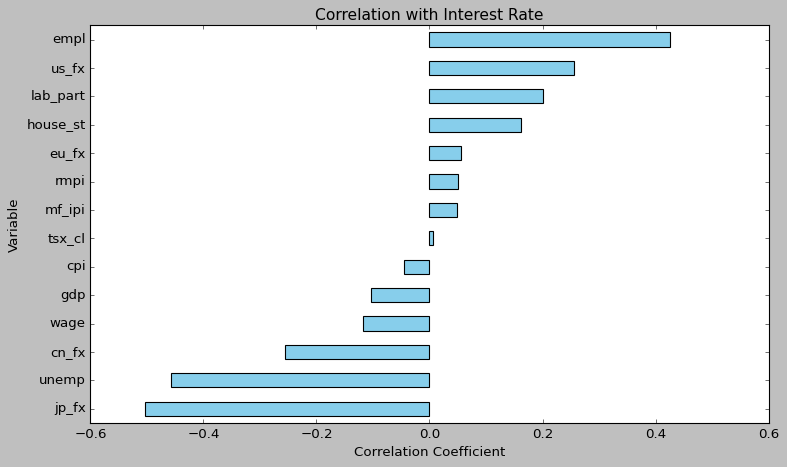

In [28]:
# Set style
plt.style.use('classic')

# Plot
plt.figure(figsize=(10, 6))
rate_correlation.plot(kind='barh', color='skyblue', edgecolor='black')
plt.title('Correlation with Interest Rate', fontsize=14)
plt.xlabel('Correlation Coefficient')
plt.ylabel('Variable')
plt.gca().invert_yaxis()  # Highest correlation at the top
plt.tight_layout()
plt.show()

While some variables show very little correlation with the corresponding interest rate, more patterns will show up when lagged variables are included. The interest rate decisions the central bank makes are rarely based on the current month's data, but on the data from the previous months. It also takes time for effects from changes in something like the raw materials price index and foreign exchange rates to trickle down through the manufacturing sector and into retail sales and the consumer price index.

### Feature engineering

In [45]:
ml_df = data.copy()
ml_df = ml_df.reset_index()

In [30]:
# categorical target - rate_change
ml_df['rate_diff'] = ml_df['rate'].diff().fillna(0)
ml_df['rate_change'] = ml_df['rate_diff'].apply(lambda x: -1 if x < 0 else (1 if x > 0 else 0))

ml_df['rate_change'].unique()

array([ 0, -1,  1])

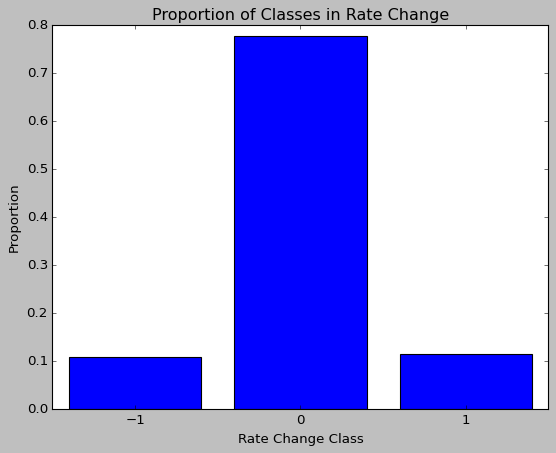

In [31]:
plt.style.use('classic')
# plot class proportions
rate_change_counts = ml_df['rate_change'].value_counts()
proportions = rate_change_counts / len(ml_df)

plt.figure(figsize=(8, 6))
plt.bar(proportions.index, proportions.values)
plt.xlabel("Rate Change Class")
plt.ylabel("Proportion")
plt.title("Proportion of Classes in Rate Change")
plt.xticks(proportions.index)
plt.show()

the classes are certainly imbalanced, with 'no change' dominating. Increase and decrease classes look fairly balanced against each other

In [32]:
ml_df['Date'] = pd.to_datetime(ml_df['Date'])

Can an LSTM pick up on seasonal trends? Yes, but having a month and quarter indicator can assist in picking up trends.

In [33]:
# date features
ml_df['year'] = ml_df['Date'].dt.year
ml_df['month'] = ml_df['Date'].dt.month
ml_df['quarter'] = ml_df['Date'].dt.quarter

In [ ]:
# deviation from mean interest rate of 2.24% - mean for last 25 years
ml_df['rate_dev'] = ml_df['rate'] - 2.24

https://www.bankofcanada.ca/rates/indicators/key-variables/inflation-control-target/

In [48]:
ml_df['cpi_pctchg12'] = ml_df['cpi'].pct_change(periods=12) * 100  # % inflation over 12 months
ml_df['cpi_dev'] = ml_df['cpi_pctchg12'] - 2.0

In [ ]:
# deviation from target inflation rate
# ml_df['cpi_target_dev'] = ml_df['cpi'] - 2.0

# ml_df['interest_rate_dev_outside_band'] = ml_df['interest_rate'].apply(
#    lambda x: 0 if 1.0 <= x <= 3.0 else (1.0 - x if x < 1.0 else x - 3.0)
# )

In [34]:
ml_df.shape

(288, 23)

In [47]:
# need to add deviations from the mean

def create_lag_features(df, feature_list,
                        pct_windows=[1,3,12],
                        ema_spans=[3,6,9],
                        rolling_std_windows=[3,6],
                        rolling_mean_windows=[3,6],
                        trend_lags=[3,6,9]):
    """
    Add engineered features for each feature in feature_list to df.

    For each feature, creates:
      - percent changes over pct_windows
      - EMAs for ema_spans
      - rolling std dev for rolling_std_windows
      - deviation from rolling mean for rolling_mean_windows
      - trend as diff of deviation and lagged trends for trend_lags

    Returns a new DataFrame with added columns.

    Parameters:
    - df: pandas DataFrame, original data
    - feature_list: list of str, column names to process
    - pct_windows: list of ints, windows for pct_change
    - ema_spans: list of ints, spans for EMA smoothing
    - rolling_std_windows: list of ints, windows for rolling std dev
    - rolling_mean_windows: list of ints, windows for rolling mean in deviation
    - trend_lags: list of ints, lag periods for trend lag features

    """

    df_new = df.copy()

    for feat in feature_list:
        # Percent changes
        for w in pct_windows:
            colname = f'{feat}_pctchg{w}'
            df_new[colname] = df_new[feat].pct_change(periods=w)

        # EMAs
        for span in ema_spans:
            colname = f'{feat}_ema{span}'
            df_new[colname] = df_new[feat].ewm(span=span, adjust=False).mean()

        # Rolling std dev (volatility)
        for w in rolling_std_windows:
            colname = f'{feat}_rolling_std{w}'
            df_new[colname] = df_new[feat].rolling(window=w).std()

        # Deviation from rolling mean
        for w in rolling_mean_windows:
            roll_mean_col = f'{feat}_rolling_mean{w}'
            dev_col = f'{feat}_diff_rolling_mean{w}'

            # Compute rolling mean if not exists
            if roll_mean_col not in df_new.columns:
                df_new[roll_mean_col] = df_new[feat].rolling(window=w).mean()

            df_new[dev_col] = df_new[feat] - df_new[roll_mean_col]

        # Trend and lagged trends based on deviation with the longest rolling mean window
        dev_col = f'{feat}_diff_rolling_mean{max(rolling_mean_windows)}'
        trend_col = f'{feat}_trend'
        df_new[trend_col] = df_new[dev_col].diff()

        for lag in trend_lags:
            lag_col = f'{feat}_trend_lag{lag}'
            df_new[lag_col] = df_new[trend_col].shift(lag)

    return df_new

 wage          288 non-null    float64
 2   rmpi          288 non-null    float64
 3   cpi           288 non-null    float64
 4   house_st      288 non-null    float64
 5   unemp         288 non-null    float64
 6   empl          288 non-null    float64
 7   lab_part      288 non-null    float64
 8   gdp           288 non-null    float64
 9   mf_ipi        288 non-null    float64
 10  us_fx         288 non-null    float64
 11  cn_fx         288 non-null    float64
 12  eu_fx         288 non-null    float64
 13  jp_fx         288 non-null    float64
 14  tsx_cl        288 non-null    float64
 15  rate          288 non-null    float64
 16  announcement  288 non-null    int64  

In [ ]:
features_list = ['wage',
                 'rmpi',
                 'cpi',
                 'house_st',
                 'unemp',
                 'empl',
                 'lab_part',
                 'gdp',
                 'mf_ipi',
                 'us_fx',
                 'cn_fx',
                 'eu_fx',
                 'jp_fx',
                 'tsx_cl',
                 #'rate',
                 ]

In [ ]:
features_to_process = ['cpi', 'exchange_rate', 'wages', 'unemployment_rate']

ml_df = create_lag_features(ml_df, features_to_process)

In [35]:
# cpi rolling window - mean
ml_df['cpi_rolling_mean3'] = ml_df['cpi'].squeeze().rolling(window=3).mean()
ml_df['cpi_rolling_mean6'] = ml_df['cpi'].squeeze().rolling(window=6).mean()
ml_df['cpi_rolling_mean9'] = ml_df['cpi'].squeeze().rolling(window=9).mean()

In [36]:
print(type(ml_df['cpi']))
print(ml_df['cpi'].shape)
print(ml_df['cpi'].head())

<class 'pandas.core.series.Series'>
(288,)
0    96.3
1    96.8
2    97.1
3    97.8
4    98.6
Name: cpi, dtype: float64


In [37]:

# cpi exp. moving avg - ema
ml_df['cpi_ema3'] = ml_df['cpi'].ewm(span = 3).mean()
ml_df['cpi_ema6'] = ml_df['cpi'].ewm(span = 6).mean()
ml_df['cpi_ema9'] = ml_df['cpi'].ewm(span = 9).mean()

In [38]:
# cpi volatility
ml_df['cpi_rolling_std3'] = ml_df['cpi'].rolling(window = 3).std()
ml_df['cpi_rolling_std6'] = ml_df['cpi'].rolling(window = 6).std()

In [39]:
ml_df['cpi_diff_rolling_mean3'] = ml_df['cpi'] - ml_df['cpi_rolling_mean3']
ml_df['cpi_diff_rolling_mean6'] = ml_df['cpi'] - ml_df['cpi_rolling_mean6']

In [40]:
# inflation deviation
ml_df['inflation_dev'] = ml_df['cpi_pctchg12'] - 2
ml_df['inflation_dev_lag3'] = ml_df['inflation_dev'].shift(3)
ml_df['inflation_dev_lag6'] = ml_df['inflation_dev'].shift(6)
ml_df['inflation_dev_lag9'] = ml_df['inflation_dev'].shift(9)

KeyError: 'cpi_pctchg12'

In [ ]:

# inflation trend - stabilizing or worsening?
ml_df['inflation_trend'] = ml_df['inflation_dev'].diff()
ml_df['inflation_trend_lag3'] = ml_df['inflation_trend'].shift(3)
ml_df['inflation_trend_lag6'] = ml_df['inflation_trend'].shift(6)
ml_df['inflation_trend_lag9'] = ml_df['inflation_trend'].shift(9)

In [ ]:
ml_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 276 entries, 12 to 287
Columns: 158 entries, index to tsx_cl_pctchg12
dtypes: datetime64[ns](2), float64(144), int32(6), int64(6)
memory usage: 336.4 KB


Now that lag features have been added, there will be some NA values in the first year of the data. These rows will need to be cut

In [ ]:
ml_df[ml_df.isna().any(axis=1)]

,index,Date,wage,rmpi,cpi,house_st,unemp,empl,lab_part,gdp,...,jp_fx_lag12,jp_fx_pctchg12,tsx_cl_lag1,tsx_cl_pctchg1,tsx_cl_lag3,tsx_cl_pctchg3,tsx_cl_lag6,tsx_cl_pctchg6,tsx_cl_lag12,tsx_cl_pctchg12


In [ ]:
ml_df

,index,Date,wage,rmpi,cpi,house_st,unemp,empl,lab_part,gdp,...,jp_fx_lag12,jp_fx_pctchg12,tsx_cl_lag1,tsx_cl_pctchg1,tsx_cl_lag3,tsx_cl_pctchg3,tsx_cl_lag6,tsx_cl_pctchg6,tsx_cl_lag12,tsx_cl_pctchg12
12,12,2002-01-01,663.15,56.4,97.6,184.910,8.0,61.0,66.3,1463177.0,...,0.012875,-0.062990,7688.410000,-0.005192,6885.700000,0.110779,7689.690000,-0.005358,9321.870000,-0.179511
13,13,2002-02-01,659.88,57.7,98.2,155.942,7.9,61.1,66.3,1471175.0,...,0.013096,-0.087813,7648.490000,-0.001437,7425.650000,0.028529,7399.220000,0.032203,8078.720000,-0.054615
14,14,2002-03-01,667.23,60.9,98.9,173.521,7.9,61.3,66.5,1469679.0,...,0.012829,-0.055343,7637.500000,0.028016,7688.410000,0.021209,6838.560000,0.148117,7608.000000,0.032002
15,15,2002-04-01,672.20,61.6,99.5,166.574,7.7,61.4,66.5,1480103.0,...,0.012588,-0.039244,7851.470000,-0.023955,7648.490000,0.001948,6885.700000,0.112943,7946.630000,-0.035643
16,16,2002-05-01,671.50,62.3,99.7,186.095,7.8,61.6,66.7,1482323.0,...,0.012670,-0.031728,7663.390000,-0.000947,7637.500000,0.002439,7425.650000,0.031038,8161.870000,-0.061964
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,283,2024-08-01,1273.80,139.4,161.8,199.374,6.7,61.0,65.4,2272581.0,...,0.009300,0.003226,22577.109091,0.010550,22216.350000,0.026960,21116.205000,0.080464,20292.620000,0.124315
284,284,2024-09-01,1277.47,134.8,161.1,210.951,6.6,61.0,65.2,2278859.0,...,0.009150,0.036066,22815.300000,0.031300,21841.665000,0.077272,21846.435000,0.077037,19541.270000,0.204088
285,285,2024-10-01,1284.22,140.2,161.8,225.165,6.6,60.8,65.2,2285235.0,...,0.009170,0.001091,23529.410000,0.036708,22577.109091,0.080436,21973.340909,0.110124,19204.652381,0.270167
286,286,2024-11-01,1285.64,139.8,161.8,247.800,6.9,60.9,65.4,2279818.0,...,0.009160,-0.006550,24393.122727,0.025149,22815.300000,0.096044,22216.350000,0.125594,19897.900000,0.256745


## LSTM Model

In [ ]:
# 1. Shift labels from {-1, 0, 1} to {0, 1, 2}
rate_change_shifted = ml_df['rate_change'] + 1

# 2. Prepare features
X = ml_df.drop(columns=['rate', 'rate_change'])
X = X.select_dtypes(exclude=['datetime64[ns]', 'datetime64[ns, UTC]'])

# 3. Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. Train-test split
split_point = int(len(X_scaled) * 0.8)
X_train = X_scaled[:split_point]
X_test = X_scaled[split_point:]
rate_train = rate_change_shifted[:split_point]
rate_test = rate_change_shifted[split_point:]

# 5. Convert rate_train and rate_test to numpy arrays before one-hot encoding
# Select only one of the duplicated 'rate_change' columns
y_train = to_categorical(rate_train.iloc[:, 0].to_numpy(), num_classes=3)
y_test = to_categorical(rate_test.iloc[:, 0].to_numpy(), num_classes=3)




X_train_seq shape: (208, 12, 152)
y_train_seq shape: (208, 3)
Epoch 1/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - accuracy: 0.6618 - loss: 0.8302 - val_accuracy: 0.6591 - val_loss: 0.9212
Epoch 2/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.8190 - loss: 0.5113 - val_accuracy: 0.6591 - val_loss: 0.9196
Epoch 3/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8659 - loss: 0.3817 - val_accuracy: 0.6591 - val_loss: 0.9299
Epoch 4/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8418 - loss: 0.3881 - val_accuracy: 0.6591 - val_loss: 0.9271
Epoch 5/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7911 - loss: 0.4259 - val_accuracy: 0.6591 - val_loss: 0.8944
Epoch 6/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8795 - loss: 0.3209 - val_accuracy: 0.6591 - val_loss: 0.8877
Epoch 7/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8413 - loss: 0.3894 - val_accuracy: 0.6591 - val_loss: 0.8763
Epoch 8/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/ste

In [ ]:
# 6. Sequence creation function
def create_sequences(X, y, time_steps=12):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:i + time_steps])
        # Take the label at the end of the sequence
        y_seq.append(y[i + time_steps])
    return np.array(X_seq), np.array(y_seq)

time_steps = 12
X_train_seq, y_train_seq = create_sequences(X_train, y_train, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, time_steps)

print("X_train_seq shape:", X_train_seq.shape)  # (samples, 12, features)
print("y_train_seq shape:", y_train_seq.shape)  # (samples, 3)

In [ ]:
 # Build LSTM model
model1 = Sequential([
    Input(shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')  # 3 classes
])

model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# 8. Train model with EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history1 = model1.fit(
    X_train_seq, y_train_seq,
    epochs=30,
    batch_size=16,
    validation_data=(X_test_seq, y_test_seq),
    callbacks=[early_stop]
)

Epoch 1/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.4806 - loss: 0.9827 - val_accuracy: 0.5000 - val_loss: 1.1036
Epoch 2/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8339 - loss: 0.5682 - val_accuracy: 0.5000 - val_loss: 0.9798
Epoch 3/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8626 - loss: 0.4312 - val_accuracy: 0.5000 - val_loss: 0.9923
Epoch 4/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8398 - loss: 0.4388 - val_accuracy: 0.4545 - val_loss: 0.9906
Epoch 5/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8663 - loss: 0.3623 - val_accuracy: 0.4545 - val_loss: 1.0211
Epoch 6/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.8329 - loss: 0.3855 - val_accuracy: 0.4545 - val_loss: 1.0115
Epoch 7/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8210 - loss: 0.3838 - val_accuracy: 0.5227 - val_loss: 1.0090


Model 1 shows signs of overfitting - the validation accuracy is significantly lower than training accuracy.

In [ ]:
K.clear_session()

model2 = Sequential([
    Input(shape=(X_train_seq.shape[1], X_train_seq.shape[2])),

    # First LSTM layer returns sequences to feed next LSTM
    Bidirectional(LSTM(64, return_sequences=True)),
    BatchNormalization(),
    Dropout(0.3),

    # Second LSTM layer outputs the final feature vector
    LSTM(32, return_sequences=False),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    Dropout(0.4),

    Dense(3, activation='softmax')  # output layer
])

model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history2 = model2.fit(
    X_train_seq, y_train_seq,
    epochs=30,
    batch_size=16,
    validation_data=(X_test_seq, y_test_seq),
    callbacks=[early_stop]
)

Epoch 1/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 117ms/step - accuracy: 0.5883 - loss: 0.9437 - val_accuracy: 0.6591 - val_loss: 0.9613
Epoch 2/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7502 - loss: 0.6461 - val_accuracy: 0.6591 - val_loss: 0.9227
Epoch 3/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7816 - loss: 0.5862 - val_accuracy: 0.6591 - val_loss: 0.9128
Epoch 4/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8088 - loss: 0.5119 - val_accuracy: 0.6591 - val_loss: 0.9096
Epoch 5/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8134 - loss: 0.5150 - val_accuracy: 0.6591 - val_loss: 0.9061
Epoch 6/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7726 - loss: 0.6109 - val_accuracy: 0.6591 - val_loss: 0.9024
Epoch 7/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8543 - loss: 0.4683 - val_accuracy: 0.6591 - val_loss: 0.9120
Epoch 8/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.7690 - loss: 0.5856 - val_accuracy: 0.6591 - 

Model 2 is an improvement over model 1. validation accuracy seems to have hit a training ceiling.

In [ ]:
K.clear_session()

model3 = Sequential([
    Input(shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    Bidirectional(LSTM(128, return_sequences=True)),
    BatchNormalization(),
    Dropout(0.3),

    LSTM(64, return_sequences=True),
    BatchNormalization(),
    Dropout(0.3),

    LSTM(32, return_sequences=False),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(3, activation='softmax')
])

model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience = 10, restore_best_weights=True)

history3 = model3.fit(
    X_train_seq, y_train_seq,
    epochs=50,
    batch_size=16,
    validation_data=(X_test_seq, y_test_seq),
    callbacks=[early_stop]
)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.7737 - loss: 0.6199 - val_accuracy: 0.6591 - val_loss: 0.8651
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.8042 - loss: 0.6002 - val_accuracy: 0.6591 - val_loss: 0.8547
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.7913 - loss: 0.6580 - val_accuracy: 0.6591 - val_loss: 0.8839
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.8055 - loss: 0.5195 - val_accuracy: 0.6591 - val_loss: 0.8663
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.8005 - loss: 0.6212 - val_accuracy: 0.6591 - val_loss: 0.8521
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.8430 - loss: 0.4186 - val_accuracy: 0.6591 - val_loss: 0.8330
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.8348 - loss: 0.4364 - val_accuracy: 0.6591 - val_loss: 0.8538
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8473 - loss: 0.4568 - val_accuracy: 0.6591 - 

or model 3 i increased the patience to 10 and added more epochs, but still stopping at 13 epochs. model is hitting a generalization limit or data issues - the data set is fairly small. Time to mess with learning rate

In [ ]:
# Clear previous models from memory
K.clear_session()

# Define optimizer with a lower learning rate
optimizer = Adam(learning_rate=0.0005)

# Build the model
model4 = Sequential([
    Input(shape=(X_train_seq.shape[1], X_train_seq.shape[2])),

    Bidirectional(LSTM(128, return_sequences=True)),
    BatchNormalization(),
    Dropout(0.3),

    LSTM(64, return_sequences=False),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    Dropout(0.4),

    Dense(3, activation='softmax')
])

model4.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])



In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Train the model
history4 = model4.fit(
    X_train_seq, y_train_seq,
    epochs=50,
    batch_size=32,
    validation_data=(X_test_seq, y_test_seq),
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 249ms/step - accuracy: 0.1752 - loss: 2.1882 - val_accuracy: 0.5455 - val_loss: 1.0616 - learning_rate: 5.0000e-04
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - accuracy: 0.3094 - loss: 1.6772 - val_accuracy: 0.6364 - val_loss: 1.0416 - learning_rate: 5.0000e-04
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.4021 - loss: 1.3865 - val_accuracy: 0.5682 - val_loss: 1.0381 - learning_rate: 5.0000e-04
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.6065 - loss: 1.1303 - val_accuracy: 0.6591 - val_loss: 0.9990 - learning_rate: 5.0000e-04
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.6794 - loss: 0.8103 - val_accuracy: 0.6591 - val_loss: 0.9582 - learning_rate: 5.0000e-04
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.6169 - loss: 0.7803 - val_accuracy: 0.6591 - val_loss: 0.9211 - learning_rate: 5.0000e-04
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.6653 - loss: 0